<a href="https://colab.research.google.com/github/HelaniChathu/Colab/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-alpha0

     |████████████████████████████████| 79.9MB 56kB/s 
     |████████████████████████████████| 3.0MB 50.8MB/s 
     |████████████████████████████████| 419kB 45.7MB/s 
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [32]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!ls "/content/drive/My Drive/Colab Notebooks"

CDClassification.ipynb	sampleSubmission.csv  testSet.zip   train.zip
Classification.ipynb	test1.zip	      trainSet.zip


In [0]:
train_file = "/content/drive/My Drive/Colab Notebooks/trainSet.zip"

In [0]:
import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [0]:
import os
import cv2

def load_image(file_path):
    return cv2.imread(file_path)

def extract_label(file_name):
    return 1 if "patterned" in file_name else 0

train_path = "./trainSet/"
image_files = os.listdir(train_path)
train_images = [load_image(train_path + file) for file in image_files]
train_labels = [extract_label(file) for file in image_files]

In [0]:
def preprocess_image(img, side=96):
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side]
    img = cv2.resize(img, (side,side))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

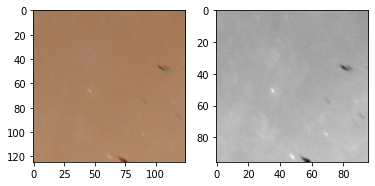

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

preview_index = 200
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")

In [0]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [42]:
import numpy as np

train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(313, 96, 96, 1) (313,)


In [43]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

Tensorflow: 2.0.0-alpha0


In [45]:
layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=5, batch_size=50)
model.save_weights("model.tf")

Epoch 1/5
313/313 [==============================] - 2s 7ms/sample - loss: 0.6780 - sparse_categorical_accuracy: 0.7125
Epoch 2/5
313/313 [==============================] - 2s 6ms/sample - loss: 0.6317 - sparse_categorical_accuracy: 0.7157
Epoch 3/5
313/313 [==============================] - 2s 6ms/sample - loss: 0.5899 - sparse_categorical_accuracy: 0.7157
Epoch 4/5
313/313 [==============================] - 2s 6ms/sample - loss: 0.3918 - sparse_categorical_accuracy: 0.7732
Epoch 5/5
313/313 [==============================] - 2s 6ms/sample - loss: 0.2458 - sparse_categorical_accuracy: 0.9425


In [54]:
from google.colab import files
uploads = files.upload()

Saving  (5).png to  (5) (2).png
Saving  (6).png to  (6) (2).png
Saving  (10).png to  (10) (2).png
Saving  (11).png to  (11) (2).png


In [55]:
uploads.keys()


dict_keys([' (5).png', ' (6).png', ' (10).png', ' (11).png'])

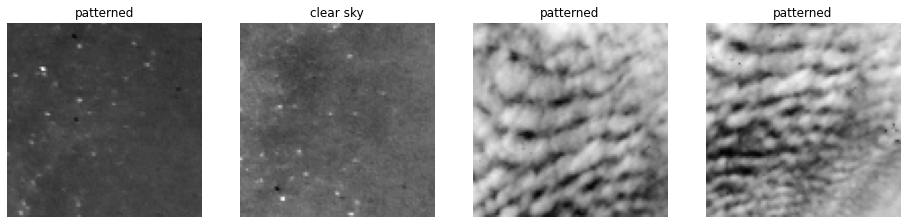

In [56]:
eval_images = [preprocess_image(load_image(file)) for file in uploads.keys()]
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(eval_images, axis=-1))

cols = 4
rows = np.ceil(len(eval_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)
for i in range(len(eval_images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(eval_images[i], cmap="gray")
    plt.title("patterned" if np.argmax(eval_predictions[i])==1 else "clear sky")
    plt.axis('off')